In [1]:
import torch
import numpy as np
import gradoptics as optics
import matplotlib.pyplot as plt

# Creating a custom optical element

### Creating an interface between two mediums

**For now, we will use the world coordinate system and assume that the surface is parallel to the yz plane**

In [2]:
from gradoptics.optics.base_optics import BaseOptics

class MediumInterface(BaseOptics):
    """
    Flat surface that defines an interface between two mediums with different indices of refraction
    """
    
    def __init__(self, xpos, n_ext, n_medium):
        """
        :param xpos: Position of the interface along the optical axis (:obj:`float`)
        :param n_ext: Index of refraction of the outside (:obj:`float`)
        :param n_medium: Index of refraction of the medium (:obj:`float`)
        """
        self.xpos = xpos
        self.n_ext = n_ext
        self.n_medium = n_medium

**Every optical element inherits from the abstract class BaseOptics, and should implement the functions get_ray_intersection, intersect and plot.**

In [3]:
def get_ray_intersection(self, incident_rays):
    
    t = (self.xpos - incident_rays.origins[:, 0]) / incident_rays.directions[:, 0]
    return t

In [4]:
def intersect(self, incident_rays, t):
    
    directions = incident_rays.directions
        
    # Normal of the interface
    normal = torch.zeros(directions.shape, device=directions.device, dtype=directions.dtype)
    normal[:, 0] = 1
    # Check for each ray if it is coming from the left
    condition = directions[:, 0] > 0
    # Flip the normal for the rays coming from the right
    normal[~condition] *= -1

    mu = torch.zeros(directions.shape[0])
    mu[condition] = self.n_medium / self.n_ext # The rays coming from the left come from the medium
    mu[~condition] = self.n_ext / self.n_medium # The rays coming from the right come from the outside

    # See https://physics.stackexchange.com/questions/435512/snells-law-in-vector-form
    tmp = 1 - mu ** 2 * (1 - (optics.optics.vector.dot_product(normal, directions)) ** 2)
    
    mask = tmp >= 0 # Killing the rays for which there is total internal reflection
    
    c = optics.optics.vector.dot_product(normal[mask], directions[mask])
    direction_refracted_rays = torch.sqrt(tmp[mask]).unsqueeze(1) * normal[mask] + mu[mask].unsqueeze(1) * (
                directions - c.unsqueeze(1) * normal)

    return (optics.Rays(incident_rays(t)[mask], direction_refracted_rays, 
                            luminosities=incident_rays.luminosities[mask] if incident_rays.luminosities is not None else None,
                            device=incident_rays.device), 
            mask)

In [5]:
def plot(self, ax):
    
    Y = np.arange(-.5, .5, 0.01)
    Z = np.arange(-.5, .5, 0.01)
    Y, Z = np.meshgrid(Y, Z)
    X = np.zeros_like(Y) + self.xpos

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z)

**Putting it all together.**

In [6]:
from gradoptics.optics.base_optics import BaseOptics

class MediumInterface(BaseOptics):
    """
    Flat surface that defines an interface between two mediums with different indices of refraction
    """
    
    def __init__(self, xpos, n_ext, n_medium):
        """
        :param xpos: Position of the interface along the optical axis (:obj:`float`)
        :param n_ext: Index of refraction of the outside (:obj:`float`)
        :param n_medium: Index of refraction of the medium (:obj:`float`)
        """
        self.xpos = xpos
        self.n_ext = n_ext
        self.n_medium = n_medium
        
    def get_ray_intersection(self, incident_rays):

        t = (self.xpos - incident_rays.origins[:, 0]) / incident_rays.directions[:, 0]
        return t
    
    def intersect(self, incident_rays, t):

        directions = incident_rays.directions
        
        # Normal of the medium
        normal = torch.zeros(directions.shape, device=directions.device, dtype=directions.dtype)
        normal[:, 0] = 1
        
        # Check for each ray if it is coming from the left
        condition = directions[:, 0] > 0
        # Flip the normal for the rays coming from the right
        normal[~condition] *= -1
        
        mu = torch.zeros(directions.shape[0])
        mu[condition] = self.n_medium / self.n_ext # The rays coming from the left come from the medium
        mu[~condition] = self.n_ext / self.n_medium # The rays coming from the right come from the outside
        
        # See https://physics.stackexchange.com/questions/435512/snells-law-in-vector-form
        tmp = 1 - mu ** 2 * (1 - (optics.optics.vector.dot_product(normal, directions)) ** 2)
        mask = tmp >= 0 # Killing the rays for which there is total internal reflection
        c = optics.optics.vector.dot_product(normal[mask], directions[mask])
        direction_refracted_rays = torch.sqrt(tmp[mask]).unsqueeze(1) * normal[mask] + mu[mask].unsqueeze(1) * (
                    directions - c.unsqueeze(1) * normal)
        
        return (optics.Rays(incident_rays(t)[mask], direction_refracted_rays, 
                            luminosities=incident_rays.luminosities[mask] if incident_rays.luminosities is not None else None,
                            device=incident_rays.device), 
                mask)
    
    def plot(self, ax):
        
        Y = np.arange(-.5, .5, 0.01)
        Z = np.arange(-.5, .5, 0.01)
        Y, Z = np.meshgrid(Y, Z)
        X = np.zeros_like(Y) + self.xpos

        # Plot the surface.
        surf = ax.plot_surface(X, Y, Z)

**Creating a scene with a MediumInterface.**

In [7]:
interface = MediumInterface(.2, 1., 1.005)

In [8]:
# Creating a scene
f = 0.05
m = 0.15
lens = optics.PerfectLens(f=f, na=1 / 1.4, position=[0., 0., 0.], m=m)
sensor = optics.Sensor(position=(-f * (1 + m), 0, 0))
atom_cloud = optics.AtomCloud(n=int(1e6), f=2, position=[f * (1 + m) / m, 0., 0.], phi=0.1)
light_source = optics.LightSourceFromDistribution(atom_cloud)
scene = optics.Scene(light_source)
scene.add_object(lens)
scene.add_object(interface)
scene.add_object(sensor)

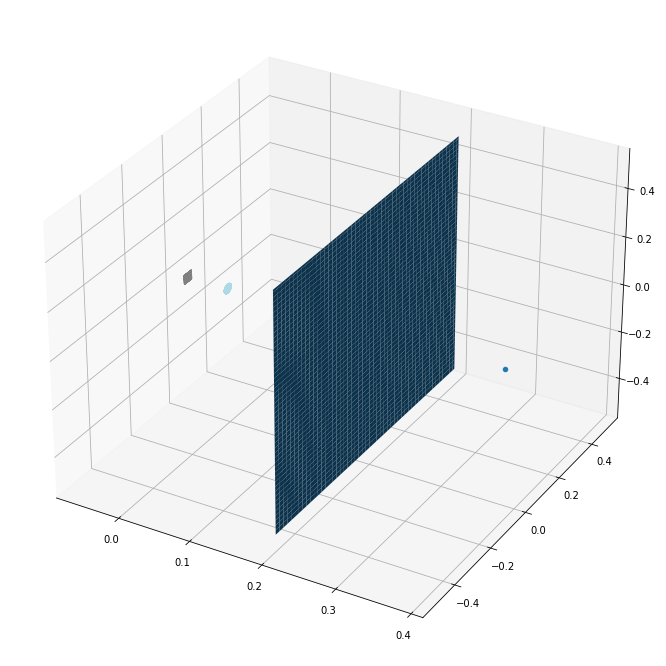

In [9]:
# Vizualizing the scene
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
scene.plot(ax)

**Producing different images with different indices of refraction.**

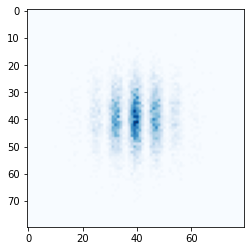

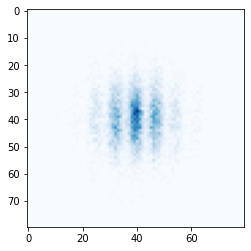

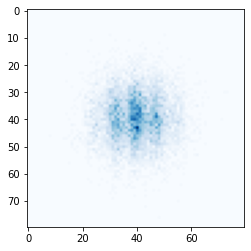

In [10]:
for n_medium in [1., 1.005, 1.01]:
    
    c = MediumInterface(.2, 1., n_medium)
    
    # Creating a scene
    f = 0.05
    m = 0.15
    lens = optics.PerfectLens(f=f, na=1 / 1.4, position=[0., 0., 0.], m=m)
    sensor = optics.Sensor(position=(-f * (1 + m), 0, 0))
    atom_cloud = optics.AtomCloud(n=int(1e6), f=2, position=[f * (1 + m) / m, 0., 0.], phi=0.1)
    light_source = optics.LightSourceFromDistribution(atom_cloud)
    scene = optics.Scene(light_source)
    scene.add_object(lens)
    scene.add_object(c)
    scene.add_object(sensor)
    
    # Producing an image
    device = 'cpu'
    for batch in range(2):
        rays = light_source.sample_rays(10_000_000, device=device)
        
        # /!\ Setting max iteration to 3 because the rays will intersect 3 optical elements (interface -> lens -> sensor)
        optics.forward_ray_tracing(rays, scene, max_iterations=3)

    # Readout the sensor
    c = (4800, 4800)
    w = 40
    produced_image = sensor.readout(add_poisson_noise=False).data.cpu().numpy()
    plt.imshow(produced_image[c[0] - w : c[0] + w, c[1] - w : c[1] + w], cmap='Blues')
    plt.show()

### Adding a transform

**Minor modifications to the developed code can be incorporated in order to shift and orient the interface easily.**

**This can be done by adding a transform in the constructor and using it in the class functions to switch back and forth between the world space and the object space.**

In [11]:
from gradoptics.optics.base_optics import BaseOptics

class MediumInterface(BaseOptics):
    """
    Flat surface that defines an interface between two mediums with different indices of refraction
    """
    
    def __init__(self, n_ext, n_medium, transform):
        """
        :param n_ext: Index of refraction of the outside (:obj:`float`)
        :param n_medium: Index of refraction of the medium (:obj:`float`)
        :param transform: :param transform: Transform to orient the interface (:py:class:`~gradoptics.transforms.base_transform.BaseTransform`)
        """  
        self.n_ext = n_ext
        self.n_medium = n_medium
        self.transform = transform
        
    def get_ray_intersection(self, incident_rays):
        
        incident_rays = self.transform.apply_inverse_transform(incident_rays)  # World space to object space

        # Now working with a local coordinate system at the center of the plane interface
        t = - incident_rays.origins[:, 0] / incident_rays.directions[:, 0]
        return t
    
    def intersect(self, incident_rays, t):
        
        incident_rays = self.transform.apply_inverse_transform(incident_rays)  # World space to object space

        directions = incident_rays.directions
        
        # Normal of the medium
        normal = torch.zeros(directions.shape, device=directions.device, dtype=directions.dtype)
        normal[:, 0] = 1
        
        # Check for each ray if it is coming from the left
        condition = directions[:, 0] > 0
        # Flip the normal for the rays coming from the right
        normal[~condition] *= -1
        
        mu = torch.zeros(directions.shape[0])
        mu[condition] = self.n_medium / self.n_ext # The rays coming from the left come from the medium
        mu[~condition] = self.n_ext / self.n_medium # The rays coming from the right come from the outside
        
        # See https://physics.stackexchange.com/questions/435512/snells-law-in-vector-form
        tmp = 1 - mu ** 2 * (1 - (optics.optics.vector.dot_product(normal, directions)) ** 2)
        mask = tmp >= 0 # Killing the rays for which there is total internal reflection
        c = optics.optics.vector.dot_product(normal[mask], directions[mask])
        direction_refracted_rays = torch.sqrt(tmp[mask]).unsqueeze(1) * normal[mask] + mu[mask].unsqueeze(1) * (
                    directions - c.unsqueeze(1) * normal)
        
        refracted_rays =  optics.Rays(incident_rays(t)[mask], direction_refracted_rays, 
                                      luminosities=incident_rays.luminosities[mask] if incident_rays.luminosities is not None else None,
                                      device=incident_rays.device)
    
        return self.transform.apply_transform(refracted_rays), mask
    
    def plot(self, ax):
        
        Y = torch.arange(-.5, .5, 0.01)
        Z = torch.arange(-.5, .5, 0.01)
        Y, Z = torch.meshgrid(Y, Z)
        X = torch.zeros_like(Y)
        
        # coordinates to world space
        xyz = self.transform.apply_transform_(torch.cat((X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1)), dim=1))

        # Plot the surface.
        surf = ax.plot_surface(xyz[:, 0].reshape(X.shape).numpy(), 
                               xyz[:, 1].reshape(X.shape).numpy(),
                               xyz[:, 2].reshape(X.shape).numpy())

In [12]:
transform = optics.simple_transform.SimpleTransform(10, 40, 10, torch.tensor([1, 0, 0]))
c = MediumInterface(1., 1., transform)

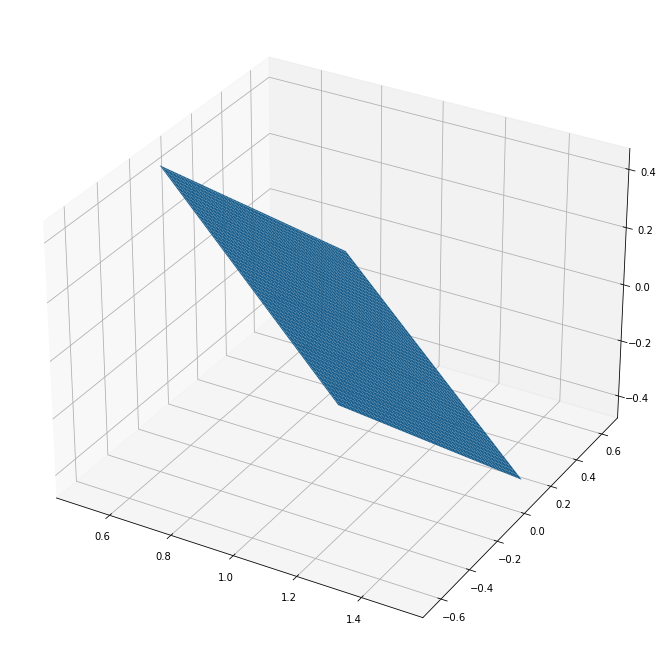

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
c.plot(ax)

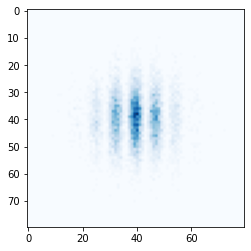

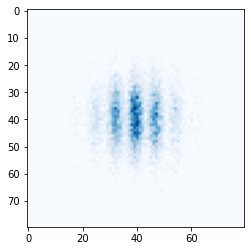

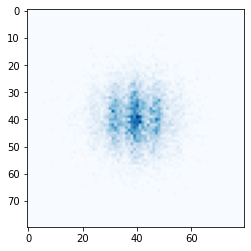

In [14]:
for n_medium in [1., 1.005, 1.01]:
    
    transform = optics.simple_transform.SimpleTransform(0, 0, 0, torch.tensor([.2, 0, 0]))
    c = MediumInterface(1., n_medium, transform)
    
    # Creating a scene
    f = 0.05
    m = 0.15
    lens = optics.PerfectLens(f=f, na=1 / 1.4, position=[0., 0., 0.], m=m)
    sensor = optics.Sensor(position=(-f * (1 + m), 0, 0))
    atom_cloud = optics.AtomCloud(n=int(1e6), f=2, position=[f * (1 + m) / m, 0., 0.], phi=0.1)
    light_source = optics.LightSourceFromDistribution(atom_cloud)
    scene = optics.Scene(light_source)
    scene.add_object(lens)
    scene.add_object(c)
    scene.add_object(sensor)
    
    # Producing an image
    device = 'cpu'
    for batch in range(2):
        rays = light_source.sample_rays(10_000_000, device=device)
        optics.forward_ray_tracing(rays, scene, max_iterations=3)

    # Readout the sensor
    c = (4800, 4800)
    w = 40
    produced_image = sensor.readout(add_poisson_noise=False).data.cpu().numpy()
    plt.imshow(produced_image[c[0] - w : c[0] + w, c[1] - w : c[1] + w], cmap='Blues')
    plt.show()